In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
import seaborn as sns
from scipy.signal import spectrogram

# Charger les fichiers CSV
df_relaxation = pd.read_csv('nia_data_relaxation_2.csv')
df_observation = pd.read_csv('nia_data_observation_2.csv')
df_lecture = pd.read_csv('nia_data_lecture_2.csv')

df_relaxation['timestamp'] = pd.to_datetime(df_relaxation['timestamp'], unit='s')
df_observation['timestamp'] = pd.to_datetime(df_observation['timestamp'], unit='s')
df_lecture['timestamp'] = pd.to_datetime(df_lecture['timestamp'], unit='s')

In [42]:
# Prétraitement des données (normalisation)
def normalize(df):
    return (df - df.mean()) / df.std()

df_relaxation_normalized = normalize(df_relaxation)
df_observation_normalized = normalize(df_observation)
df_lecture_normalized = normalize(df_lecture)

C:\Users\gdaie\AppData\Local\Temp\ipykernel_3368\2925330253.py:3: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  return (df - df.mean()) / df.std()
C:\Users\gdaie\AppData\Local\Temp\ipykernel_3368\2925330253.py:3: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  return (df - df.mean()) / df.std()
C:\Users\gdaie\AppData\Local\Temp\ipykernel_3368\2925330253.py:3: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  return (df - df.mean()) / df.std()


In [43]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs  # Fréquence de Nyquist
    low = lowcut / nyq
    high = highcut / nyq
    if low <= 0 or high >= 1:
        raise ValueError("Les fréquences critiques doivent être dans l'intervalle (0, 1).")
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Paramètres du filtre ajustés
lowcut = 0.5  # Fréquence de coupure basse (en Hz)
highcut = 19.9  # Fréquence de coupure haute (en Hz), légèrement inférieure à 20
fs = 40  # Fréquence d'échantillonnage (en Hz)

# Application du filtre sur les données normalisées
df_relaxation_filtered = df_relaxation_normalized.apply(lambda x: bandpass_filter(x, lowcut, highcut, fs))
df_observation_filtered = df_observation_normalized.apply(lambda x: bandpass_filter(x, lowcut, highcut, fs))
df_lecture_filtered = df_lecture_normalized.apply(lambda x: bandpass_filter(x, lowcut, highcut, fs))


In [56]:
import pandas as pd

def segment_data(df, segment_length=10, sampling_rate=40):
    one_minute_points = 60 * sampling_rate  # Nombre de points de données dans une minute
    trimmed_df = df.iloc[one_minute_points:-one_minute_points]  # Exclusion des premières et dernières minutes

    segment_size = segment_length * sampling_rate  # Nombre de points de données par segment
    num_segments = len(trimmed_df) // segment_size  # Nombre total de segments

    segments = []
    for i in range(num_segments):
        segment = trimmed_df.iloc[i * segment_size:(i + 1) * segment_size]
        segments.append(segment)
    return segments

# Exemple d'utilisation avec vos jeux de données
segments_relaxation = segment_data(df_relaxation_filtered)
segments_observation = segment_data(df_observation_filtered)
segments_lecture = segment_data(df_lecture_filtered)

print(f"Nombre de segments pour la relaxation: {len(segments_relaxation)}")
print(f"Nombre de segments pour l'observation: {len(segments_observation)}")
print(f"Nombre de segments pour la lecture: {len(segments_lecture)}")


Nombre de segments pour la relaxation: 60
Nombre de segments pour l'observation: 60
Nombre de segments pour la lecture: 60


In [57]:
import numpy as np
from scipy.signal import spectrogram


def generate_spectrogram(data, fs):
    segment_length = len(data)
    nperseg = min(segment_length, 64)  # Utiliser une taille de fenêtre adaptée à la longueur du segment
    noverlap = nperseg // 2  # Utiliser la moitié de nperseg pour le chevauchement
    f, t, Sxx = spectrogram(data, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=256)
    Sxx = np.abs(Sxx)  # Utiliser uniquement la magnitude des valeurs complexes
    Sxx = Sxx.astype(float)  # Convertir en float pour éviter les problèmes de type
    Sxx[Sxx == 0] = 1e-10  # Remplacer les zéros par une petite valeur pour éviter les -inf dans log10
    return t, f, 10 * np.log10(Sxx)

def compute_spectrograms(segments, fs):
    spectrograms = []
    for segment in segments:
        _, _, Sxx = generate_spectrogram(segment.values.flatten(), fs)
        spectrograms.append(Sxx)
    return np.array(spectrograms)

# Calcul des spectrogrammes
fs = 40  # Fréquence d'échantillonnage
spectrograms_relaxation = compute_spectrograms(segments_relaxation, fs)
spectrograms_observation = compute_spectrograms(segments_observation, fs)
spectrograms_lecture = compute_spectrograms(segments_lecture, fs)

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer

def create_cnn_model(input_shape):
    model = Sequential([
        InputLayer(input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(3, activation='softmax')  # 3 classes
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Préparation des données
X = np.vstack((spectrograms_relaxation, spectrograms_observation, spectrograms_lecture))
y = np.array([0] * len(spectrograms_relaxation) +
             [1] * len(spectrograms_observation) +
             [2] * len(spectrograms_lecture))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Redimensionnement des données
X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(-1, X_test.shape[1], X_test.shape[2], 1)

# Création et entraînement du modèle
model = create_cnn_model((X_train.shape[1], X_train.shape[2], 1))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Évaluation du modèle
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.5f}")


Epoch 1/10


C:\Users\gdaie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.2551 - loss: 147.0636 - val_accuracy: 0.3056 - val_loss: 38.7289
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.3521 - loss: 21.3527 - val_accuracy: 0.3333 - val_loss: 3.7087
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.3326 - loss: 2.8894 - val_accuracy: 0.3056 - val_loss: 1.2821
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.3119 - loss: 1.2609 - val_accuracy: 0.2500 - val_loss: 1.1040
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.4280 - loss: 1.0967 - val_accuracy: 0.4167 - val_loss: 1.0950
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.5315 - loss: 1.0653 - val_accuracy: 0.3333 - val_loss: 1.1067
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.4284 - loss: 1.0676 - val_accuracy: 0.3611 - val_loss: 1.1442
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.5595 - loss: 0.9670 - val_accuracy: 0.3889 - val_loss: 1.1144

In [59]:
# Redimensionner les données pour qu'elles aient trois canaux
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Vérification de la forme des données
print(X_train_rgb.shape)
print(X_test_rgb.shape)


(144, 129, 86, 3)
(36, 129, 86, 3)


In [60]:
import cv2
import numpy as np

# Redimensionner les données pour qu'elles soient au moins de 75x75 pixels
def resize_data(data, new_shape=(75, 75)):
    resized_data = []
    for img in data:
        resized_img = cv2.resize(img, new_shape)
        resized_data.append(resized_img)
    return np.array(resized_data)

# Redimensionner les ensembles de données
X_train_rgb_resized = resize_data(X_train_rgb, new_shape=(75, 75))
X_test_rgb_resized = resize_data(X_test_rgb, new_shape=(75, 75))

# Vérification de la forme des données
print(X_train_rgb_resized.shape)
print(X_test_rgb_resized.shape)



(144, 75, 75, 3)
(36, 75, 75, 3)


In [61]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Définir la forme d'entrée basée sur les données redimensionnées
input_shape = (75, 75, 3)

# Chargement du modèle pré-entraîné MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Ajouter de nouvelles couches de sortie adaptées à votre problème
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Geler les couches de base du modèle MobileNetV2
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(X_train_rgb_resized, y_train, epochs=20, validation_data=(X_test_rgb_resized, y_test))

# Évaluation du modèle
test_loss, test_acc = model.evaluate(X_test_rgb_resized, y_test)
print(f"Test Accuracy: {test_acc:.5f}")


C:\Users\gdaie\AppData\Local\Temp\ipykernel_3368\3183019484.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 392ms/step - accuracy: 0.3288 - loss: 8.2297 - val_accuracy: 0.3333 - val_loss: 7.8806
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3792 - loss: 4.4000 - val_accuracy: 0.2778 - val_loss: 4.2774
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3303 - loss: 3.4152 - val_accuracy: 0.3333 - val_loss: 3.1551
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2999 - loss: 2.5137 - val_accuracy: 0.3611 - val_loss: 1.6083
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3479 - loss: 1.4744 - val_accuracy: 0.3056 - val_loss: 1.4770
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4311 - loss: 1.2875 - val_accuracy: 0.3889 - val_loss: 1.3656
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4086 - loss: 1.2409 - val_accuracy: 0.3056 - val_loss: 1.6801
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.3767 - loss: 1.3697 - val_accuracy: 0.3333 - val_loss: 1.673

In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(X_train_rgb_resized)


In [63]:
from tensorflow.keras.applications import ResNet50

# Chargement du modèle pré-entraîné ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Ajouter de nouvelles couches de sortie adaptées à votre problème
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Geler les couches de base du modèle ResNet50
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle avec augmentation des données
history = model.fit(datagen.flow(X_train_rgb_resized, y_train, batch_size=32), epochs=20, validation_data=(X_test_rgb_resized, y_test))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Epoch 1/20


C:\Users\gdaie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 603ms/step - accuracy: 0.4235 - loss: 1.9906 - val_accuracy: 0.3056 - val_loss: 3.3215
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.4060 - loss: 1.5037 - val_accuracy: 0.3611 - val_loss: 2.1320
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.4374 - loss: 1.3926 - val_accuracy: 0.3333 - val_loss: 1.3082
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.3661 - loss: 1.4445 - val_accuracy: 0.4167 - val_loss: 1.3431
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.2902 - loss: 1.4842 - val_accuracy: 0.3611 - val_loss: 1.7914
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.3764 - loss: 1.2632 - val_accuracy: 0.3611 - val_loss: 1.3363
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.3708 - loss: 1.2819 - val_accuracy: 0.4167 - val_loss: 1.2100
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.3912 - loss: 1.2367 - val_accuracy: 0.3889 - val_loss: 1.1616
Epo

In [64]:
from tensorflow.keras.layers import Dropout

# Ajouter des couches de dropout au modèle
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Ajout d'un dropout de 50%
predictions = Dense(3, activation='softmax')(x)

# Modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Geler les couches de base du modèle
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle avec augmentation des données
history = model.fit(datagen.flow(X_train_rgb_resized, y_train, batch_size=32), epochs=20, validation_data=(X_test_rgb_resized, y_test))


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 672ms/step - accuracy: 0.3685 - loss: 2.1254 - val_accuracy: 0.3056 - val_loss: 1.7050
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.3984 - loss: 1.9764 - val_accuracy: 0.4167 - val_loss: 1.2888
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.3248 - loss: 2.0184 - val_accuracy: 0.3056 - val_loss: 2.2511
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.3826 - loss: 1.8301 - val_accuracy: 0.3056 - val_loss: 1.9857
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.3741 - loss: 1.7723 - val_accuracy: 0.4167 - val_loss: 1.1768
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.3626 - loss: 1.8191 - val_accuracy: 0.3611 - val_loss: 1.4937
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.3605 - loss: 1.5826 - val_accuracy: 0.3056 - val_loss: 1.7681
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.3312 - loss: 1.7085 - val_accuracy: 0.3611 - val_loss:

In [65]:
# Débloquer certaines des dernières couches du modèle de base pour l'entraînement
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompiler le modèle après modification des couches entraînables
model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle avec fine-tuning
history = model.fit(datagen.flow(X_train_rgb_resized, y_train, batch_size=32), epochs=20, validation_data=(X_test_rgb_resized, y_test))


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 702ms/step - accuracy: 0.4093 - loss: 1.0551 - val_accuracy: 0.3611 - val_loss: 1.3358
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.4085 - loss: 1.0792 - val_accuracy: 0.3611 - val_loss: 1.3366
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step - accuracy: 0.4506 - loss: 1.0929 - val_accuracy: 0.3611 - val_loss: 1.3383
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - accuracy: 0.3863 - loss: 1.1192 - val_accuracy: 0.3611 - val_loss: 1.3376
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step - accuracy: 0.4047 - loss: 1.0966 - val_accuracy: 0.3611 - val_loss: 1.3337
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - accuracy: 0.4532 - loss: 1.1386 - val_accuracy: 0.3611 - val_loss: 1.3276
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 0.4224 - loss: 1.0712 - val_accuracy: 0.3611 - val_loss: 1.3256
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.4001 - loss: 1.1470 - val_accuracy: 0.3611 - val_loss

In [66]:
# Évaluation du modèle
test_loss, test_acc = model.evaluate(X_test_rgb_resized, y_test)
print(f"Test Accuracy: {test_acc:.5f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3657 - loss: 1.2143
Test Accuracy: 0.36111


In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Chargement des données
file_path_relaxation = 'nia_data_relaxation_2.csv'
file_path_observation = 'nia_data_observation_2.csv'
file_path_lecture = 'nia_data_lecture_2.csv'

data_relaxation = pd.read_csv(file_path_relaxation)
data_observation = pd.read_csv(file_path_observation)
data_lecture = pd.read_csv(file_path_lecture)


In [79]:

# Ajout des étiquettes aux ensembles de données
data_relaxation['label'] = 0  # Relaxation
data_observation['label'] = 1  # Observation
data_lecture['label'] = 2  # Lecture

# Combinaison des ensembles de données
data_combined = pd.concat([data_relaxation, data_observation, data_lecture], ignore_index=True)

# Séparation des caractéristiques (X) et de la cible (y)
X = data_combined[['low_alpha', 'med_alpha', 'high_alpha', 'low_beta', 'med_beta', 'high_beta']]
y = data_combined['label']

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [80]:

# Initialisation et entraînement du modèle RandomForest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Prédictions et évaluation du modèle
y_pred = clf.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_pred)
print(f"Initial Test Accuracy: {initial_accuracy:.2f}")


Initial Test Accuracy: 0.73


In [ ]:


# Définition des paramètres à tester pour la recherche des meilleurs paramètres
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialisation du modèle RandomForest
rf = RandomForestClassifier(random_state=42)

# Recherche des meilleurs paramètres
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Entraînement du modèle avec les meilleurs paramètres
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Prédictions et évaluation du modèle avec les meilleurs paramètres
y_pred_best = best_rf.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Test Accuracy with best parameters: {best_accuracy:.2f}")


In [81]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# Charger les nouvelles données
new_file_path_relaxation = 'nia_data_Relaxation.csv'
new_file_path_observation = 'nia_data_Observation.csv'
new_file_path_lecture = 'nia_data_Lecture.csv'

new_data_relaxation = pd.read_csv(new_file_path_relaxation)
new_data_observation = pd.read_csv(new_file_path_observation)
new_data_lecture = pd.read_csv(new_file_path_lecture)

# Ajout des étiquettes aux nouveaux ensembles de données
new_data_relaxation['label'] = 0  # Relaxation
new_data_observation['label'] = 1  # Observation
new_data_lecture['label'] = 2  # Lecture

# Combinaison des nouvelles données
new_data_combined = pd.concat([new_data_relaxation, new_data_observation, new_data_lecture], ignore_index=True)


In [82]:
# Séparation des caractéristiques (X_new) et de la cible (y_new)
X_new = new_data_combined[['low_alpha', 'med_alpha', 'high_alpha', 'low_beta', 'med_beta', 'high_beta']]
y_new = new_data_combined['label']


In [83]:
# Prédictions avec le modèle entraîné (best_rf est le modèle entraîné et optimisé)
y_pred_new = best_rf.predict(X_new)

# Convertir les prédictions en noms d'activités
activity_labels = {0: 'Relaxation', 1: 'Observation', 2: 'Lecture'}
predicted_activities = [activity_labels[label] for label in y_pred_new]

# Afficher les prédictions
for i, activity in enumerate(predicted_activities):
    print(f"Segment {i+1}: {activity}")


Segment 1: Lecture
Segment 2: Observation
Segment 3: Lecture
Segment 4: Relaxation
Segment 5: Relaxation
Segment 6: Relaxation
Segment 7: Relaxation
Segment 8: Relaxation
Segment 9: Observation
Segment 10: Observation
Segment 11: Observation
Segment 12: Observation
Segment 13: Relaxation
Segment 14: Relaxation
Segment 15: Relaxation
Segment 16: Relaxation
Segment 17: Relaxation
Segment 18: Relaxation
Segment 19: Relaxation
Segment 20: Relaxation
Segment 21: Relaxation
Segment 22: Relaxation
Segment 23: Relaxation
Segment 24: Relaxation
Segment 25: Relaxation
Segment 26: Relaxation
Segment 27: Relaxation
Segment 28: Relaxation
Segment 29: Relaxation
Segment 30: Relaxation
Segment 31: Relaxation
Segment 32: Relaxation
Segment 33: Observation
Segment 34: Observation
Segment 35: Observation
Segment 36: Relaxation
Segment 37: Relaxation
Segment 38: Relaxation
Segment 39: Lecture
Segment 40: Observation
Segment 41: Relaxation
Segment 42: Lecture
Segment 43: Observation
Segment 44: Lecture
Se

In [84]:
# Évaluer les performances sur les nouvelles données
new_accuracy = accuracy_score(y_new, y_pred_new)
print(f"Test Accuracy on new data: {new_accuracy:.2f}")

Test Accuracy on new data: 0.36


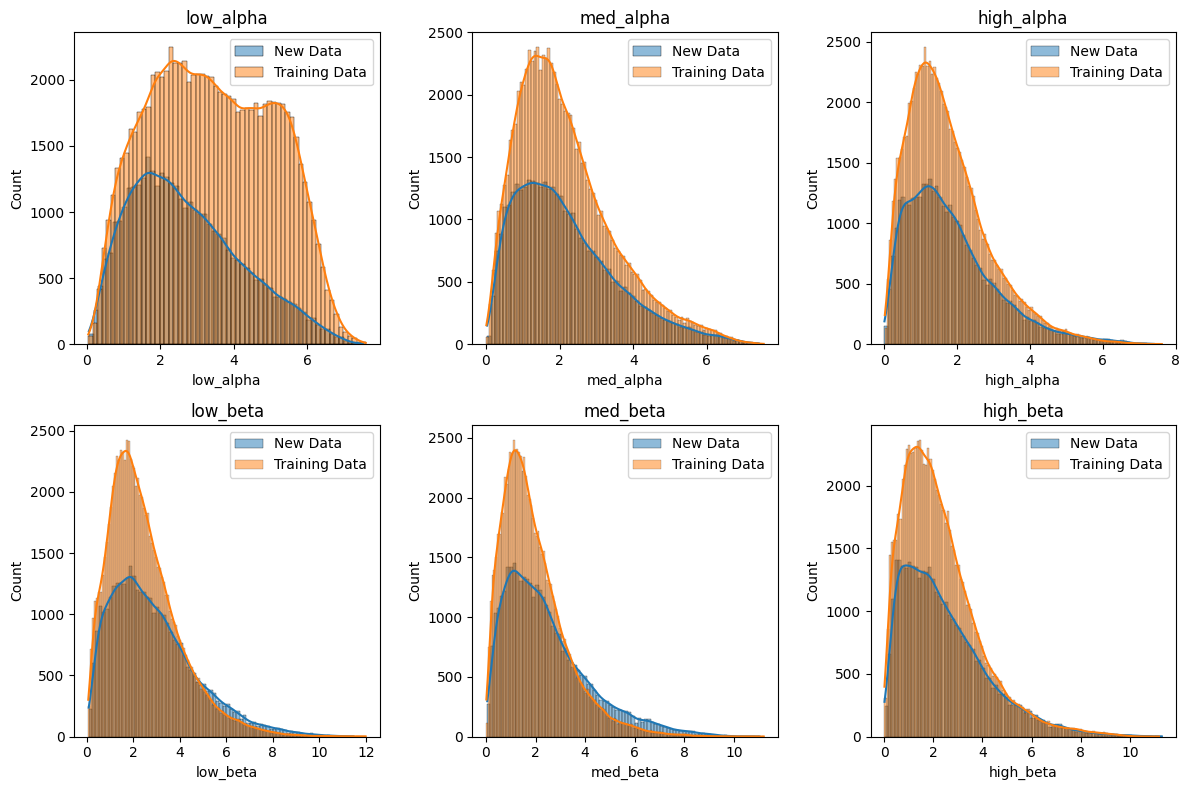

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisation des distributions des caractéristiques
plt.figure(figsize=(12, 8))
for i, col in enumerate(['low_alpha', 'med_alpha', 'high_alpha', 'low_beta', 'med_beta', 'high_beta']):
    plt.subplot(2, 3, i + 1)
    sns.histplot(new_data_combined[col], kde=True, label='New Data')
    sns.histplot(data_combined[col], kde=True, label='Training Data')
    plt.legend()
    plt.title(col)
plt.tight_layout()
plt.show()


In [86]:
# Combinaison des anciennes et nouvelles données
data_combined_full = pd.concat([data_combined, new_data_combined], ignore_index=True)

# Séparation des caractéristiques (X_full) et de la cible (y_full)
X_full = data_combined_full[['low_alpha', 'med_alpha', 'high_alpha', 'low_beta', 'med_beta', 'high_beta']]
y_full = data_combined_full['label']

# Division des données en ensembles d'entraînement et de test
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# Réentraîner le modèle RandomForest avec toutes les données
best_rf.fit(X_train_full, y_train_full)

# Prédictions et évaluation du modèle sur l'ensemble de test complet
y_pred_full = best_rf.predict(X_test_full)
full_accuracy = accuracy_score(y_test_full, y_pred_full)
print(f"Test Accuracy on combined data: {full_accuracy:.2f}")


Test Accuracy on combined data: 0.72


In [87]:
from sklearn.model_selection import cross_val_score

# Utiliser la validation croisée pour évaluer le modèle
cv_scores = cross_val_score(best_rf, X_full, y_full, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {cv_scores.mean():.2f}")


Cross-validation accuracy scores: [0.3551383  0.36563699 0.37011912 0.3697557  0.37041673]
Mean cross-validation accuracy: 0.37


In [92]:
import pandas as pd

# Fonction pour extraire des caractéristiques avancées pour chaque ligne
def extract_features(df):
    features = pd.DataFrame()
    features['mean_low_alpha'] = df['low_alpha']
    features['mean_med_alpha'] = df['med_alpha']
    features['mean_high_alpha'] = df['high_alpha']
    features['mean_low_beta'] = df['low_beta']
    features['mean_med_beta'] = df['med_beta']
    features['mean_high_beta'] = df['high_beta']
    features['var_low_alpha'] = df['low_alpha'] ** 2
    features['var_med_alpha'] = df['med_alpha'] ** 2
    features['var_high_alpha'] = df['high_alpha'] ** 2
    features['var_low_beta'] = df['low_beta'] ** 2
    features['var_med_beta'] = df['med_beta'] ** 2
    features['var_high_beta'] = df['high_beta'] ** 2
    return features

# Extraire des caractéristiques avancées pour chaque ligne
X_advanced = extract_features(data_combined_full)
y_advanced = data_combined_full['label']

# Vérifiez la cohérence des données après extraction des caractéristiques
print(f"Number of samples in X_advanced: {X_advanced.shape[0]}")
print(f"Number of samples in y_advanced: {y_advanced.shape[0]}")


Number of samples in X_advanced: 123824
Number of samples in y_advanced: 123824


In [93]:
from sklearn.ensemble import GradientBoostingClassifier

# Division des données en ensembles d'entraînement et de test
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(X_advanced, y_advanced, test_size=0.2, random_state=42)

# Initialisation et entraînement du modèle Gradient Boosting
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(X_train_adv, y_train_adv)


GradientBoostingClassifier(random_state=42)

In [94]:

# Prédictions et évaluation du modèle
y_pred_adv = gb_clf.predict(X_test_adv)
accuracy_adv = accuracy_score(y_test_adv, y_pred_adv)
print(f"Gradient Boosting Test Accuracy: {accuracy_adv:.2f}")


Gradient Boosting Test Accuracy: 0.43


In [ ]:

# Validation croisée
cv_scores_adv = cross_val_score(gb_clf, X_advanced, y_advanced, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores (Gradient Boosting): {cv_scores_adv}")
print(f"Mean cross-validation accuracy (Gradient Boosting): {cv_scores_adv.mean():.2f}")
